 ##### IMPORTS

In [1]:
import dmd_with_power_control_single_task as DMD
import imageio
import numpy as np
import time
from glob import glob
import os
import importlib
importlib.reload(DMD)
import napari as nap

In [2]:
XP_FOLDER = r'D:\Data\george_KC_OR_feb_19_2024' # **** D:\Data\george_KC_OR_feb_19_2024\
TARGET_FOLDER = XP_FOLDER + r'\OR_1_20240219_165825' # ***D:\Data\MBON_tests\
GENERAL_PARAMETERS = r'C:\\Users\\Light Sheet User\\Desktop\\DMD_parameters.pickled'

In [3]:
mirrors = DMD.dmd(XP_FOLDER, TARGET_FOLDER, GENERAL_PARAMETERS)
# Prints basic information about the DMD.

Loading library: C:/Program Files/ALP-4.3/ALP-4.3 API/x64/alp4395.dll
DMD found, resolution = 1920 x 1200.
DMD patterns folder already exists.


c:\Users\Light Sheet User\Documents\GitHub\DMD\dmd_with_power_control_single_task.py:42: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\\\Users\\\\Light Sheet User\\\\Desktop\\\\DMD_parameters.pickled'>
  self.parameters = pickle.load(open(general_parameters_folder, 'rb'))


##### Calibration procedure:

- project the *calibration_mask*;
- save the image through the Labview code;
- run the *find_affine* method.

The affine transorm parameters are saved for future use.

In [4]:
mirrors.project(mirrors.calibration_mask, 1.5)

dmdpowerON


In [5]:
mirrors.idle()

In [4]:
mirrors.parameters['params_folder']

'D:\\DMD_transform_parameters'

Save the calibration image. Usually choosing the same folder as **mirrors.parameters['params_folder']** is a good choice to keep things tidy.
Then plug it in the following method and run it to compute the afffine transform parameters.

1223.8 1158.2
626.0 940.0


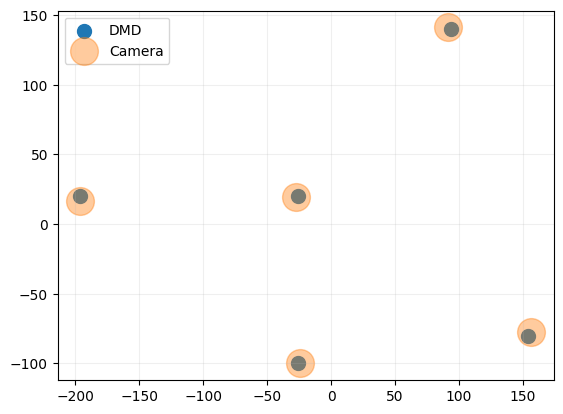

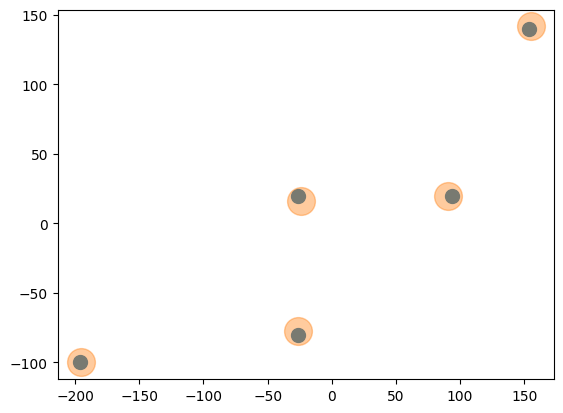

[[ 0.70417669 -0.71002478]
 [ 0.71002478  0.70417669]]


In [7]:
calibration_image = \
    r'C:\Users\Light Sheet User\Documents\GitHub\DMD\camera_DMD_calibration.png'
mirrors.find_affine(calibration_image, show=True)

#### ROI selection

Use the following method to select ROIs to be stimulated by the DMD.
It is supposed to read rectangular ROIs, where you start drawing from top left corner to bottom right corner of the ROI. Different geometries are not implemented and may result in random or no pattern at all.

In [4]:
mirrors.select_ROIs()

Once the wanted ROIs are drawn, import them within the class. They are stored in order in the "rois" list and saved as .png using the save_dir attribute.

In [5]:
mirrors.import_N_rois(exp='1_1')

Found 1 ROI(s)
Target ROI(s) folder already exists.


In [7]:
img1 = imageio.imread("D:\\Data\\Or83b_KC_george_tests\\excitation_patterns\\1_1\\mask_1.png")
mirrors.project(img1, 0.5)

dmdpowerON


C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_15452\3846497876.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread("D:\\Data\\test_dmd_2024\\excitation_patterns\\1\\mask_1.png")


In [8]:
mirrors.idle()

In [29]:
img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
mirrors.project(img1)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_21816\1891733706.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')


In case you plan to project two patterns at the same time, use the method "sum_patterns", passing a list of pattrerns to be summed as numpy matrices. It will return a new matrix that can be used for projection or for a protocol.

Random slopes

In [13]:
masks_path = r'D:\Data\KC_speed_tests\excitation_patterns\2_1'


img1 = imageio.imread(masks_path + '\\mask_1.png')
img2 = imageio.imread(masks_path + '\\mask_2.png')
# img3 = imageio.imread(masks_path + '\\mask_3.png')
# img4 = imageio.imread(masks_path + '\\mask_4.png')
# img5 = imageio.imread(masks_path + '\\mask_5.png')
# img6 = imageio.imread(masks_path + '\\mask_6.png')
tot = mirrors.sum_patterns([img1, img2])

start = time.time()

# mirrors.project_random_slopes_seqence(img2, 1.5, '2_2')

mirrors.project_finite_square_signal(tot, 5, 1, 0, 20)
time.sleep(100)
mirrors.idle()
mirrors.project_finite_square_signal(tot, 5, 1, 0, 20)
time.sleep(100)
mirrors.idle()
mirrors.project_finite_square_signal(tot, 5, 1, 0, 20)
time.sleep(100)
mirrors.idle()


# mirrors.power_titration(tot, 20, 30, 5, 1, [.005, 0.3])

# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\2_5_20240216_172528' # <-- HD: D:\Data\KC_speed_tests\
protocol_name = r"/2_5_start_waves"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

# np.savez(images_folder + protocol_name,\
#          TM=num, images=["1", "dark", "1", "dark", "1", "dark", "1", "dark", 
#                          "1", "dark", "1", "dark", "1", "dark", "1", "dark", 
#                          "1", "dark", "1", "dark", "1", "dark", "1", "dark", 
#                          "1", "dark", "1", "dark", "1", "dark", "1", "dark"
#                          ], \
#                          durations=[10, 50, 10, 50, 10, 50, 10, 50,
#                                     10, 50, 10, 50, 10, 50, 10, 50,
#                                     10, 50, 10, 50, 10, 50, 10, 50,
#                                     10, 50, 10, 50, 10, 50, 10, 50])
np.savetxt(images_folder + protocol_name, [num])


C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22584\2532177604.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22584\2532177604.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png')


In [22]:
np.savetxt(images_folder + protocol_name, [num])

In [10]:
mirrors.idle()

MBONs

In [8]:
masks_path = r'D:\Data\MBON_tests\excitation_patterns\2_1'


img1 = imageio.imread(masks_path + '\\mask_1.png') # odour1
img2 = imageio.imread(masks_path + '\\mask_2.png') # odour2
img3 = imageio.imread(masks_path + '\\mask_2.png') # pain
tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain

start = time.time()

mirrors.project(img1, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img1, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img1, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)

mirrors.project(tot, 2)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, 2)
time.sleep(10)
mirrors.idle()
time.sleep(10)



# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\2_2_20240217_151144' # <-- HD: D:\Data\MBON_tests\
protocol_name = r"/2_2"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark", "2", "dark", "1", "dark", "2", "dark", "1", "dark", "2", "dark",
                         "1p", "dark", "2", "dark", "1p", "dark", "2", "dark",  "1p", "dark", "2", "dark",  "1p", "dark", "2", "dark",  "1p", "dark", "2", "dark", 
                         "1p", "dark", "2", "dark",  "1p", "dark", "2", "dark",  "1p", "dark", "2", "dark",  "1p", "dark", "2", "dark",  "1p", "dark", "2", "dark"
                         ], \
                durations=[10, 50, 10, 50, 10, 50, 10, 50, 10, 50, 10, 50, 
                            10, 50, 10, 10, 
                            10, 50, 10, 10, 
                            10, 50, 10, 10, 
                            10, 50, 10, 10, 
                            10, 50, 10, 10,
                            10, 50, 10, 10, 
                            10, 50, 10, 10, 
                            10, 50, 10, 10, 
                            10, 50, 10, 10, 
                            10, 50, 10, 10,]
                )


C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_14872\581643174.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png') # odour1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_14872\581643174.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png') # odour2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_14872\581643174.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 



In [6]:
mirrors.idle()

NEW TITRATION

In [6]:
masks_path = r'D:\Data\george_KC_OR_feb_19_2024\excitation_patterns\1_1' # D:\Data\george_KC_OR_feb_19_2024\KC_1_20240219_171538


img1 = imageio.imread(masks_path + '\\mask_1.png')

# img2 = imageio.imread(masks_path + '\\mask_2.png')
# img3 = imageio.imread(masks_path + '\\mask_3.png')
# img4 = imageio.imread(masks_path + '\\mask_4.png')
# img5 = imageio.imread(masks_path + '\\mask_5.png')
# img6 = imageio.imread(masks_path + '\\mask_6.png')
# tot = mirrors.sum_patterns([img1, img2])

start = time.time()

mirrors.power_titration(img1, 10, 60, 1, 20, [1, 1.1])

# mirrors.power_titration(img2, 20, 30, 5, 1, [.005, 0.3])

# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\KC_1_20240219_171538' # <-- HD: D:\Data\george_KC_OR_feb_19_2024\
protocol_name = r"/1_1"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break


np.savez(images_folder + protocol_name,\
         TM=num, 
         images=["1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                 "1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                 "1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                 "1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                         ], \
                durations=[10, 60, 10, 60, 10, 60, 10, 60, 10, 60,
                           10, 60, 10, 60, 10, 60, 10, 60, 10, 60,
                           10, 60, 10, 60, 10, 60, 10, 60, 10, 60,
                           10, 60, 10, 60, 10, 60, 10, 60, 10, 60])

# np.savez(images_folder + protocol_name,\
#          TM=num, images=["1", "dark",  "1", "dark",  "1", "dark", 
#                          "1", "dark",  "1", "dark",  "1", "dark", 
#                          "1", "dark",  "1", "dark",  "1", "dark", 
#                          "2", "dark",  "2", "dark",  "2", "dark", 
#                          "2", "dark",  "2", "dark",  "2", "dark", 
#                          "2", "dark",  "2", "dark",  "2", "dark", 
#                          "3", "dark",  "3", "dark",  "3", "dark", 
#                          "3", "dark",  "3", "dark",  "3", "dark", 
#                          "3", "dark",  "3", "dark",  "3", "dark", 
#                          "4", "dark",  "4", "dark",  "4", "dark", 
#                          "4", "dark",  "4", "dark",  "4", "dark", 
#                          "4", "dark",  "4", "dark",  "4", "dark", 
                         
#                          ], \
#                          durations=[10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60])

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_7080\2842714250.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png')


Powers: [1.] 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

DMD OFF,  input voltage 0.000000 

1.0
DMD ON,  input voltage 1.000000 

In [7]:
mirrors.idle()

In [12]:
mirrors.idle()

In [12]:
# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break


np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark",  "1", "dark",  "1", "dark", 
                         "1", "dark",  "1", "dark", 
                         "2", "dark",  "2", "dark",  "2", "dark", 
                         "2", "dark",  "2", "dark"
                         
                         ], \
                         durations=[10, 60, 10, 60, 10, 60, 
                                    10, 60, 10, 60,
                                    10, 60, 10, 60, 10, 60, 
                                    10, 60, 10, 60])

In [17]:
np.linspace(.02, .02, 1)

array([0.02])

In [8]:
np.savez(images_folder + protocol_name,\
         TM=num, images=["OR1", "dark",  "OR1", "dark",  "OR1", "dark",  "OR1", "dark",  "OR1", "dark",  
                         "OR2", "dark", "OR2", "dark", "OR2", "dark", "OR2", "dark", "OR2", "dark",], \
                         durations=[30, 10, 30, 10, 30, 10, 30, 10, 30, 10, \
                                    30, 10, 30, 10, 30, 10, 30, 10, 30, 10])

In [5]:
masks_path = "D:\\Data\\KC_titration_2\\excitation_patterns\\2_1"


img1 = imageio.imread(masks_path + '\\mask_1.png')
img2 = imageio.imread(masks_path + '\\mask_2.png')

tot = mirrors.sum_patterns([img1, img2])
mirrors.project_square_power(tot, 10, 0.05, 0)
start = time.time()

# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\2_9_20240210_141832' # <-- HERE D:\Data\KC_titration_2\D:\Data\KC_titration_2\
protocol_name = r"/2_9"
images_folder = mirrors.xp_folder + current_acquisition 

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, Hz=10)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3572\1460730158.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3572\1460730158.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png')


dmdpowerON


c:\Users\Light Sheet User\anaconda3\envs\LS_2\lib\site-packages\nidaqmx\_library_interpreter.py:6034: DaqWarning: 
Warning 200015 occurred.

While writing to the buffer during a regeneration, the actual data generated might have alternated between old data and new data. That is, while the driver was replacing the old pattern in the buffer with the new pattern, the device might have generated a portion of new data, then a portion of old data, and then a portion of new data again.

Reduce the sample rate, use a larger buffer, or refer to documentation about DAQmx Write for information about other ways to avoid this warning.
  warnings.warn(DaqWarning(error_string, error_code))


DaqError: Specified operation cannot be performed while the task is running.
Task Name: power

Status Code: -200479

In [6]:
mirrors.idle()

##### SUM protocol

In [11]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'/9_2_20231027_160538' # <-- HERE: D:\Data\ramp\
protocol_name = r"/9_1"
images_folder = mirrors.xp_folder + current_acquisition 

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')
img3 = imageio.imread(mirrors.save_dir + '\\mask_3.png')

img12 = mirrors.sum_patterns([img1, img2]) # the sum
img13 = mirrors.sum_patterns([img1, img3])
img23 = mirrors.sum_patterns([img2, img3])
img123 = mirrors.sum_patterns([img1, img2, img3])

img_seq = [img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, img12, img123, img23, img3, mirrors.dark,
           img1, img12, img123, img23, img3, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark
           ]
img_seq_names = ['1', 'd', '3', 'd', '2', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', '12', '123', '23', '3', 'd',
                 '1', '12', '123', '23', '3', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', 'd', '3', 'd','2', 'd'
                ]
img_times = [10, 30, 10, 30, 10, 30,
             10, 30, 10, 30,10, 30,
             10, 30, 10, 30,10, 30,
             10, 10, 10, 10, 10, 60,
             10, 10, 10, 10, 10, 60,
             10, 30, 10, 30,10, 30,
             10, 30, 10, 30,10, 30,
             10, 30, 10, 30, 10, 30
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22100\3663936598.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22100\3663936598.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22100\3663936598.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and mak

In [15]:
mirrors.idle()

In [13]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'/test_filter_1_b__20231113_143548' # <-- HERE D:\Data\learning\
protocol_name = r"/tst_filter_1_b"
images_folder = mirrors.xp_folder + current_acquisition

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')

img_seq = [img1, mirrors.dark
           ]
img_seq_names = ['1', 'd'
                ]
img_times = [20, 20
             ]

reps = 5 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_21064\613735808.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')


In [12]:
mirrors.project(img1)

In [22]:
mirrors.idle()

In [10]:
mirrors.close()


DMD halted.
DMD closed.



#### Andre protocol

In [23]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\5_2_20230926_165438' # <-- HERED:\Data\Or83b_KC__rGeeco_ChronomVenus\5_2_20230926_165438
protocol_name = r"/5_2"
images_folder = mirrors.xp_folder + current_acquisition 

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')


img_seq = [img1, img2, img1, img2, img1, img2, mirrors.dark,
           img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, img1,mirrors.dark, img1,mirrors.dark,  img1, mirrors.dark,
            img1, img2, img1, img2, img1, img2, mirrors.dark ]
img_seq_names = ['1','2', '1','2', '1','2', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                 '1','2', '1','2', '1','2', 'dark'
                 ]
img_times = [30, 30, 30, 30, 30, 30, 60,
             30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,
             30, 30, 30, 30, 30, 30, 60,]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3744\1653027485.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3744\1653027485.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')


#### Andre protocol (OLD)

In [ ]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\5_1_20231215_115231' # <-- HERED:\Data\Or83b_KC__rGeeco_ChronomVenus\5_2_20230926_165438
protocol_name = r"/5_1"
images_folder = mirrors.xp_folder + current_acquisition 

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')


img_seq = [img1, mirrors.dark, img2,mirrors.dark, img1,mirrors.dark,
            img2, mirrors.dark, img1,mirrors.dark, img2, mirrors.dark, # test

           img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, img1,mirrors.dark, img1,mirrors.dark,  img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, img1,mirrors.dark, img1,mirrors.dark,  img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, 
           
            img1, mirrors.dark, img2,mirrors.dark, img1,mirrors.dark,
            img2, mirrors.dark, img1,mirrors.dark, img2, mirrors.dark] #test again

img_seq_names = ['1', 'dark','2', 'dark', '1', 'dark','2', 'dark', '1', 'dark','2', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                  '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                   '1', 'dark','1', 'dark',
                 '1', 'dark','2', 'dark', '1', 'dark','2', 'dark', '1', 'dark','2', 'dark'
                 ]
img_times = [10, 20, 10, 20, 10, 20, 10, 20, 10, 20, 10, 60,
             10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15,
             10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 120, # 17 times 
             10, 20, 10, 20, 10, 20, 10, 20, 10, 20, 10, 60]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

### MBON trainig protocol

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\1_1_20231030_105408' # <-- HEREDD:\Data\learning\
protocol_name = r"/1_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',
                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',
                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',
                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                 ]
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 60, 20, 5, 20, 60,
             20, 5, 20, 60, 20, 5, 20, 60,
             20, 5, 20, 60, 20, 5, 20, 60,
             20, 5, 20, 60, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_20820\2777809818.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_20820\2777809818.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_20820\2777809818.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current

KeyboardInterrupt: 

SAM PROTOCOL WITH 2 ODOURS (30.3 mins)

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\2_1_20231115_150631' # <-- HERE D:\Data\lear
protocol_name = r"/2_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_25436\3812522150.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_25436\3812522150.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_25436\3812522150.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current

Sam's protocol (LONGER)

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\9_1_20231207_115657' # <-- D:\Data\57C10__Or83b_ppk__jRGECO_iRFP__
protocol_name = r"/9_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_26988\4089100158.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_26988\4089100158.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_26988\4089100158.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current

SAME TIME (Hadi's, 21mins)

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\2_2_20231212_113818' # <-- HERE VD:\D:\DataurPostTest\2\
protocol_name = r"/2_2"
images_folder = mirrors.xp_folder + current_acquisition

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment
sum = mirrors.sum_patterns([od1, pun])

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22436\111115180.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22436\111115180.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22436\111115180.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current be

In [8]:
img_times = [
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]
tot = 0
for t in img_times:
    tot +=t
print(tot/60)

21.333333333333332


Same time and FASTER (16 mins total)

In [ ]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\8_1_20231206_112827' # <-- HERE D:\Data\57C10__Or83b_ppk__jRGECO_iRFP__ChronosmVenus__ChronosmVenus_repo-GFP\3xOdourTest_24xOdour+ppk_3xOdourPostTest\6\
protocol_name = r"/8_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment
sum = mirrors.sum_patterns([od1, pun])

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
             10, 45, 10, 45,
             10, 45, 10, 45,
             10, 45, 10, 45,

             10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 
             10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 
             
             10, 45, 10, 45,
             10, 45, 10, 45,
             10, 45, 10, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

In [7]:
img_times = [
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

tot = 0
for time in img_times:
    tot += time

print(tot/60)

21.333333333333332


In [3]:
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]
tot = 0
for time in img_times:
    tot += time
print(tot/60)

65.0


In [8]:
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]
tot = 0
for time in img_times:
    tot+= time
tot/60

30.333333333333332

In [9]:
# how to read the dmd triggers file
a = np.load(images_folder + "triggers_numpy.npz")
lst = a.files
for item in lst:
    print(item)
    print(a[item])

TM
558
images
['od1' 'dark' 'od2' 'dark' 'od3' 'dark' 'od4' 'dark' 'od3' 'dark' 'od1'
 'dark']
durations
[5 5 5 5 5 5 5 5 5 5 5 5]


### Close the DMD when done.

In [16]:
mirrors.close()


DMD halted.
DMD closed.



In [16]:
import numpy as np
a = np.load(r'D:\Data\KC_speed_tests\1_1_20240216_142207\1_1.npz')
lst = a.files
for item in lst:
    print(item)
    print(a[item])

TM
94
images
['1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1'
 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark'
 '1' 'dark' '1' 'dark' '1' 'dark']
durations
[10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50
 10 50 10 50 10 50 10 50]
